Exercise 3
## 1. Setting things up.

In [43]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import time
import numba
import pylab
import os

In [44]:
# Specify parameters
alpha_k = 0.29715
alpha_l = 0.65
delta = 0.154
psi = 1.08
w = 0.7
r= 0.04
z = 1
sigma_z = 0.213
mu = 0.000
rho = 0.7605
sizez = 9
betafirm = (1 / (1 + r))
params = alpha_k, alpha_l, delta, psi, w, r, betafirm

In [45]:
# Set up K-grid
dens = 1
# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (z ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 2 * kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
kvec = K[::-1]
sizek = kvec.shape[0]

# Set up Z-grid
import ar1_approx as ar1
num_sigma = 4
step = (num_sigma * sigma_z) / (sizez / 2)
pi, zvec = ar1.rouwen(rho, mu, step, sizez)
zvec = np.exp(zvec)

## 2. Coleman-EGM
we would like to use the Euler Equation  
$$1 + c_1(k', k) = \beta[E_{z'|z} \pi_2(z', k') + (1-\delta) - c_2(k'', k')]$$, where 
$$c_1(k', k) = \psi(k'-(1-\delta)k)$$
We would like to:
Guess a policy function k' given grid k;  
Calculate the implied level k using the Euler Equation;  
Invert the function to get the implied k' from k;  
Check for convergence between guess k' and implied k'

In [46]:
def c2(k1, k, params):
    alpha_k, alpha_l, delta, psi, w, r, betafirm = params
    c2 = (psi / 2) * ((-2)*(k1 - (1 - delta)*k)*(1 - delta)*k - (k1 - (1 - delta)*k)**2)/(k**2)
    return c2

def pi2(k, z, params):
    alpha_k, alpha_l, delta, psi, w, r, betafirm = params
    pi2 = alpha_k * (alpha_l/w) ** (alpha_l/(1 - alpha_l)) * z ** (1/(1 - alpha_l)) * k **((alpha_k - 1 + alpha_l)/(1 - alpha_l))
    return pi2

In [47]:
egtol = 1e-6
egdist = 7.0
egmaxiter = 3000

k1 = np.repeat(kvec, 9)
k1 = k1.reshape(sizek, sizez) # initial guess of k'
kgrid = np.zeros(sizek) # Initialize grid for k
k2 = np.zeros(sizez)  # initialize grid for k''
egiter = 1

start = time.time()
while egdist > egtol and egiter < egmaxiter:
    Tk = np.copy(k1)
    for i in range(sizez):  # loop over z
        for j in range(sizek):  # loop over k
            for k in range(sizez): # calculate k'' from the guess of k'
                k2[k] = np.interp(k1[j, i], kvec, k1[:, k])
            rhs = np.dot((pi2(k1[j, i], zvec, params) + (1 - delta) - (c2(k2, k1[j, i], params))), pi[:, i])
            kgrid[j] = ( psi * k1[j, i] )/( betafirm * rhs + psi * (1 - delta) - 1)
        k1[:, i] = np.interp(kvec, kgrid, k1[:, i])     
                      
    # iteration for graphing later
    egdist = (np.absolute(k1 - Tk)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    egiter += 1
end = time.time()

if egiter < egmaxiter:
    print('Policy function converged after this many iterations:', egiter)
    print('Time taken for convergence:' + str(end - start))
else:
    print('Policy function did not converge')

Policy function converged after this many iterations: 38
Time taken for convergence:1.6451377868652344


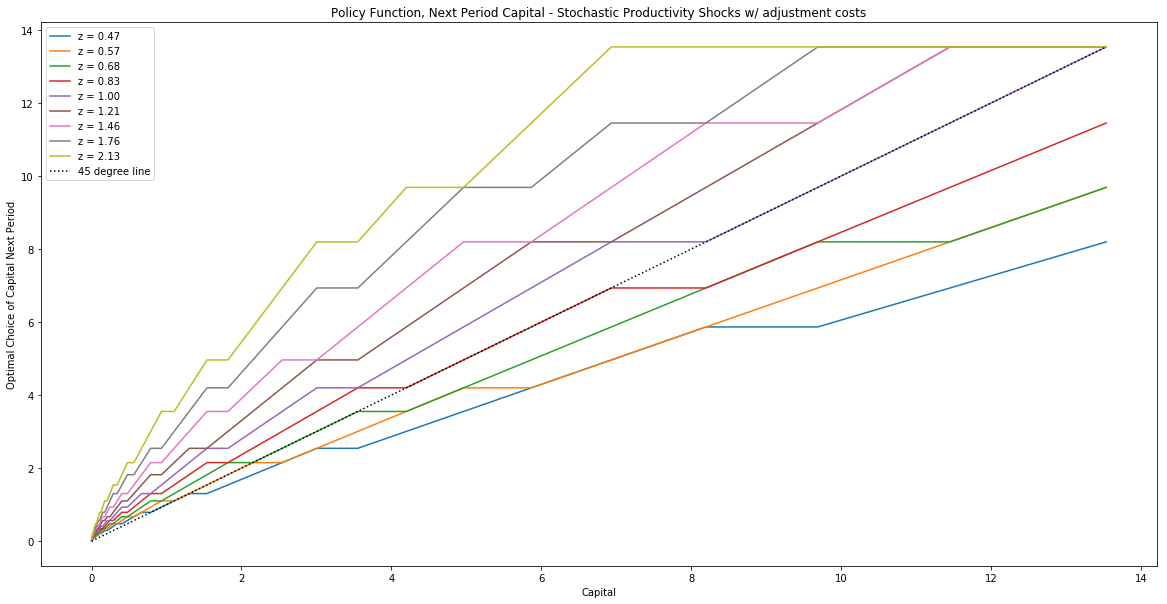

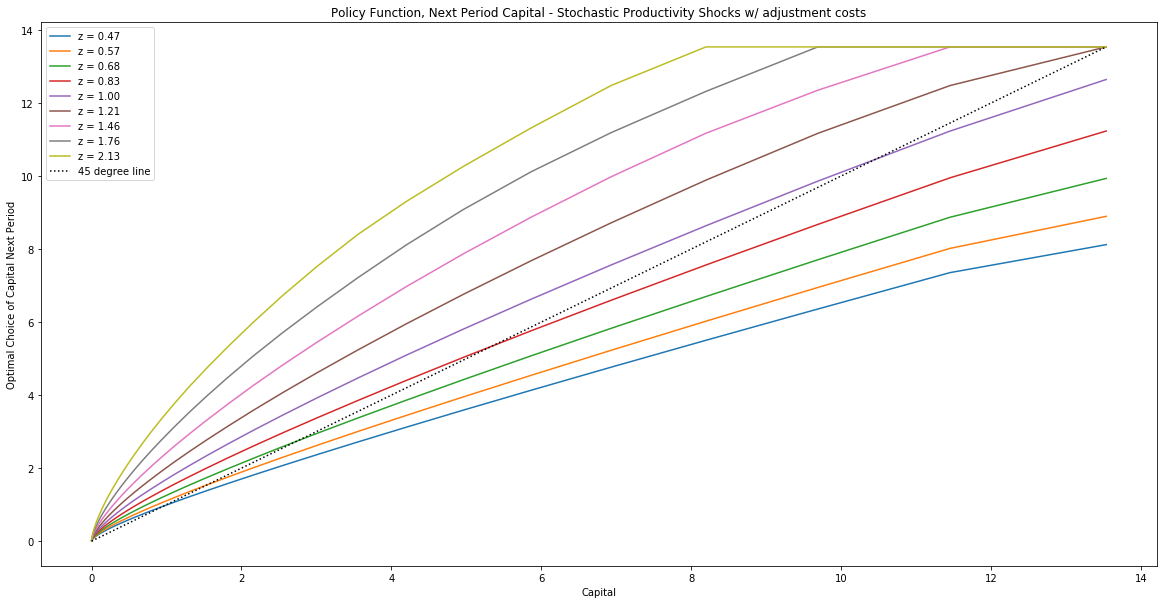

In [76]:
pylab.rcParams['figure.figsize'] = (20, 10)

from IPython.display import Image, display
display(Image(filename='capital.png'))
plt.show()

for i in range(9):
    plt.plot(kvec, k1[: ,i], label=str('z = ' + "%.2f" %zvec[i]))
plt.plot(kvec, kvec, 'k:', label='45 degree line')
plt.xlabel('Capital')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.legend()
plt.title('Policy Function, Next Period Capital - Stochastic Productivity Shocks w/ ' +
          'adjustment costs')
plt.show()

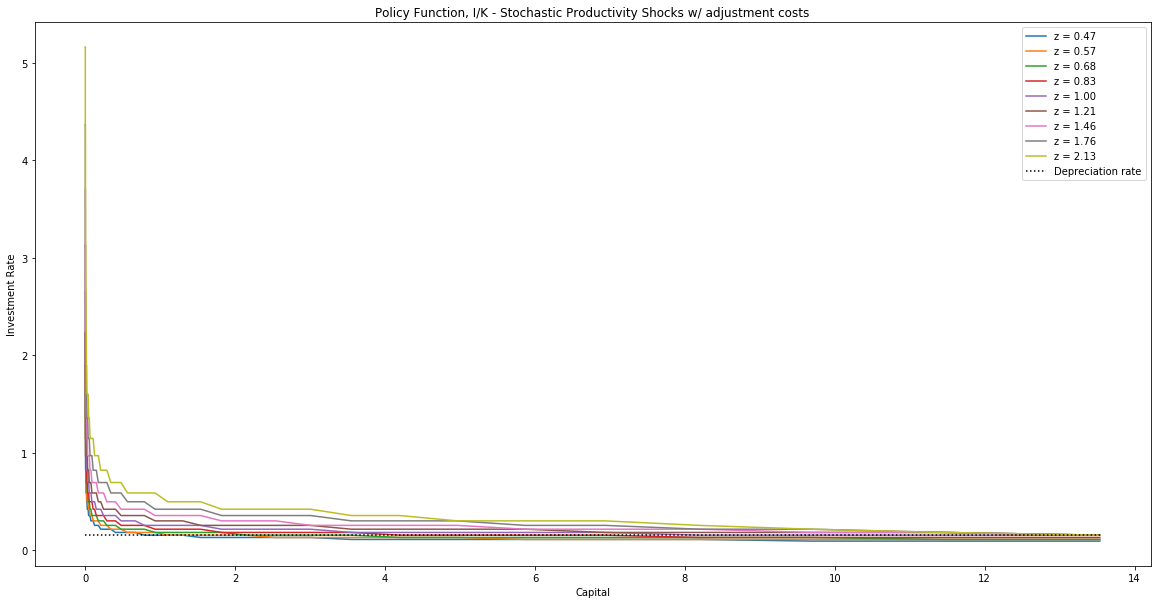

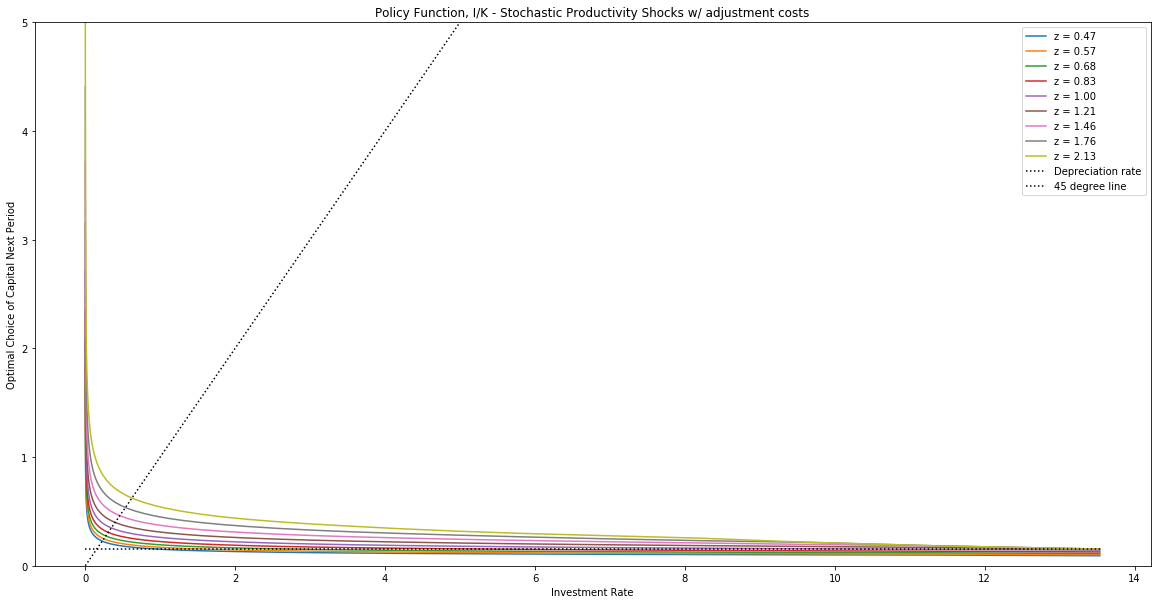

In [78]:
pylab.rcParams['figure.figsize'] = (20, 10)
from IPython.display import Image, display
display(Image(filename='investment.png'))
plt.show()

I = k1 - (1 - delta) * k1
for i in range(9):
    plt.plot(kvec, I[: ,i]/kvec, label=str('z = ' + "%.2f" %zvec[i]))
plt.plot(kvec,(np.ones(kvec.shape[0])*delta), 'k:', label='Depreciation rate')
plt.plot(kvec, kvec, 'k:', label='45 degree line')
plt.xlabel('Investment Rate')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.legend()
plt.title('Policy Function, I/K - Stochastic Productivity Shocks w/ ' +
          'adjustment costs')
plt.ylim(0, 5)
plt.show()

I am not sure how to calculate the value function from our optimal policy function. But as seen from the graphs of the policy functions, the two methods yield similar results, except for that EGM gives a smoother plot, for it interpolates values in between grid points.